# Notebook to Investigate Which Basins Have Summer Snow w/ UCLA Data

In [1]:

import json
import pandas as pd
import warnings
from snowML.datapipe.utils import data_utils as du


In [2]:
# Step 1 -Define Functions 


In [3]:
def load_UCLA_SWE(huc, filter_dates):
    file_name = f"model_ready_huc{huc}_ucla.csv"
    b = "snowml-model-ready"
    df = du.s3_to_df(file_name, b)
    df['day'] = pd.to_datetime(df['day'])
    df.set_index('day', inplace=True)  # Set 'day' as the index
    col_to_keep = ["mean_swe"]
    df = df[col_to_keep]
    if filter_dates is not None:
        df = df.loc[filter_dates[0]:filter_dates[1]]
    return df

In [4]:
def load_UA_SWE(huc, filter_dates): 
    file_name = f"model_ready_huc{huc}.csv"
    b = "snowml-model-ready"
    df = du.s3_to_df(file_name, b)
    df['day'] = pd.to_datetime(df['day'])
    df.set_index('day', inplace=True)  # Set 'day' as the index
    col_to_keep = ["mean_swe"]
    df = df[col_to_keep]
    if filter_dates is not None:
        df = df.loc[filter_dates[0]:filter_dates[1]]
    return df

In [5]:
def summer_snow(df, start_date="08-01", end_date="08-15"):
    """
    Calculates the overall mean SWE between two given MM-DD dates across all years.

    Parameters:
        df (pd.DataFrame): DataFrame with datetime index named 'day' and a column 'mean_swe'.
        start_date (str): Start date in MM-DD format (e.g., "08-01").
        end_date (str): End date in MM-DD format (e.g., "08-15").

    Returns:
        float: Overall mean SWE in the date range across all years.
    """
    # Ensure index is datetime
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    # Extract MM-DD string from index for filtering
    mmdd = df.index.strftime("%m-%d")
    mask = (mmdd >= start_date) & (mmdd <= end_date)

    # Filter the relevant rows
    df_period = df[mask]

    if df_period.empty:
        return 0.0  # Avoid returning NaN

    # Calculate and return the mean SWE
    return df_period["mean_swe"].mean()


In [6]:
def summer_snow_percent(df, delta = 0, start_date="08-01", end_date="08-15"):
    """
    Calculates the overall percentage of days with non-zero mean_swe between two given MM-DD dates across all years.

    Parameters:
        df (pd.DataFrame): DataFrame with datetime index named 'day' and a column 'mean_swe'.
        start_date (str): Start date in MM-DD format (e.g., "08-01").
        end_date (str): End date in MM-DD format (e.g., "08-30").

    Returns:
        float: Overall percentage of days with non-zero mean_swe in the date range.
    """
    # Ensure index is datetime
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    # Extract MM-DD string from index for filtering
    mmdd = df.index.strftime("%m-%d")
    mask = (mmdd >= start_date) & (mmdd <= end_date)

    # Filter the relevant rows
    df_period = df[mask]

    if len(df_period) == 0:
        return 0.0  # Avoid division by zero

    # Calculate and return percentage
    percent_nonzero = (df_period["mean_swe"] > delta).sum() / len(df_period) * 100
    return percent_nonzero


In [7]:
# Step 2 Example

In [8]:
filter_dates =  ['1984-10-01', '2021-09-30']
huc = '170200090101'
summer_start_date="08-15"
summer_end_date="08-30"
delta = 0

In [9]:
df_UCLA = load_UCLA_SWE(huc, filter_dates)
sum_snow_ucla = summer_snow(df_UCLA, start_date = summer_start_date, end_date = summer_end_date)
sum_snow_ucla

0.033726447870152026

In [10]:
df_UA = load_UA_SWE(huc, filter_dates)
sum_snow_UA = summer_snow(df_UA, start_date =summer_start_date, end_date = summer_end_date)
sum_snow_UA

0.00011683558925675675

# Step 3 -Define Summer Snow UCLA ALl Hucs

In [11]:
def summer_snow_all(huc_list, filter_dates, summer_start = "08-15", summer_end = "08-30"):
    summer_snow_UCLA = []
    summer_snow_UA=[]
    for huc in huc_list:
        df_UCLA = load_UCLA_SWE(huc, filter_dates)         
        summer_snow_UCLA.append(summer_snow(df_UCLA, start_date = summer_start, end_date = summer_end))
        df_UA = load_UA_SWE(huc, filter_dates)
        summer_snow_UA.append(summer_snow(df_UA, start_date = summer_start, end_date = summer_end))
    
    # Create a pandas DataFrame with "huc" as the index and "Summer Snow %" as the column
    df_result = pd.DataFrame({
        "huc": huc_list,
        "Summer Snow Mean UCLA": summer_snow_UCLA,
        "Summer Snow Mean UA": summer_snow_UA,
    }).set_index("huc")
    
    return df_result

In [12]:
# gather hucs 
f = "../../src/snowML/datapipe/huc_lists/MandM_hucs_.json"
with open(f, 'r', encoding='utf-8') as file:
        data = json.load(file)
hucs_mar = data["maritime_hucs"]
# remove ucla error hucs
error_ls = ['171100080201', '171100050602']
hucs_mar_clean = [huc for huc in hucs_mar if huc not in error_ls]
len(hucs_mar_clean)

152

In [13]:
# define parameters 
delta = 0.01
filter_dates =  ['1984-10-01', '2021-09-30']
summer_start = "08-15"
summer_end = "08-30"

In [14]:
summer_snow_df = summer_snow_all(hucs_mar_clean, filter_dates, summer_start = summer_start, summer_end = summer_end)
summer_snow_df.head()

,Summer Snow Mean UCLA,Summer Snow Mean UA
huc,,
170200090101,0.033726,0.000117
170200090102,0.077198,0.000021
170200090103,0.046555,0.000002
170200090104,0.150403,0.000000
170200090105,0.229865,0.004296


In [15]:
summer_snow_df.describe()

,Summer Snow Mean UCLA,Summer Snow Mean UA
count,152.000000,152.000000
mean,0.121996,0.001705
std,0.259142,0.006103
min,0.000410,0.000000
25%,0.018724,0.000000
50%,0.045166,0.000000
75%,0.112248,0.000279
max,1.869043,0.047493


# Step 4 - Compare UCLA Performance with Summer Snow

In [16]:
# get metrics 
f =  "metrics_UA_v_UCLA_maritime.csv" 
b = "snowml-results"
df_metrics = du.s3_to_df(f, b)
df_metrics["huc"] = df_metrics["huc"].astype(str)
df_metrics = df_metrics.set_index("huc")
df_metrics.head()

,test_UA_mse,test_UA_kge,test_UA_r2,test_UA_mae,test_UCLA_mse,test_UCLA_kge,test_UCLA_r2,test_UCLA_mae
huc,,,,,,,,
170200090101,0.015019,0.928918,0.912333,0.077274,0.024721,0.659060,0.635900,0.122170
170200090102,0.009633,0.881795,0.941105,0.065177,0.011363,0.744850,0.852330,0.074483
170200090103,0.006073,0.956777,0.952444,0.047646,0.010116,0.774202,0.825367,0.073897
170200090104,0.011961,0.922367,0.933535,0.073813,0.011550,0.818173,0.886278,0.084381
170200090105,0.025661,0.916319,0.890720,0.107907,0.024445,0.729314,0.784465,0.136279


In [17]:
df_merged = df_metrics.merge(summer_snow_df, left_index=True, right_index=True)
df_merged.head()

,test_UA_mse,test_UA_kge,test_UA_r2,test_UA_mae,test_UCLA_mse,test_UCLA_kge,test_UCLA_r2,test_UCLA_mae,Summer Snow Mean UCLA,Summer Snow Mean UA
huc,,,,,,,,,,
170200090101,0.015019,0.928918,0.912333,0.077274,0.024721,0.659060,0.635900,0.122170,0.033726,0.000117
170200090102,0.009633,0.881795,0.941105,0.065177,0.011363,0.744850,0.852330,0.074483,0.077198,0.000021
170200090103,0.006073,0.956777,0.952444,0.047646,0.010116,0.774202,0.825367,0.073897,0.046555,0.000002
170200090104,0.011961,0.922367,0.933535,0.073813,0.011550,0.818173,0.886278,0.084381,0.150403,0.000000
170200090105,0.025661,0.916319,0.890720,0.107907,0.024445,0.729314,0.784465,0.136279,0.229865,0.004296


In [20]:
# who are teh UCLA outliers for summer snow
df_merged_sorted = df_merged.sort_values(by="Summer Snow Mean UCLA", ascending=False)
df_merged_sorted.head()

,test_UA_mse,test_UA_kge,test_UA_r2,test_UA_mae,test_UCLA_mse,test_UCLA_kge,test_UCLA_r2,test_UCLA_mae,Summer Snow Mean UCLA,Summer Snow Mean UA
huc,,,,,,,,,,
171100060201,0.021733,0.909705,0.916158,0.101123,0.664667,0.652858,-3.933301,0.797173,1.869043,0.022717
171100051005,0.029310,0.413136,0.596688,0.097353,1.373940,0.479860,-15.762140,1.153903,1.829479,0.000000
171100050702,0.018684,0.926602,0.897567,0.096036,0.037211,0.796670,0.738922,0.152185,1.326734,0.013335
171100051002,0.045914,0.661598,0.750400,0.135934,0.190726,0.729932,-0.277542,0.403205,1.006295,0.002779
170200090107,0.006530,0.898074,0.965165,0.051510,0.018245,0.879538,0.846477,0.114364,0.580685,0.000000


In [26]:
# who are teh UCLA outliers for low KGE
df_merged_sorted_kge = df_merged.sort_values(by="test_UCLA_kge", ascending=True)
df_merged_sorted_kge.head(10)

,test_UA_mse,test_UA_kge,test_UA_r2,test_UA_mae,test_UCLA_mse,test_UCLA_kge,test_UCLA_r2,test_UCLA_mae,Summer Snow Mean UCLA,Summer Snow Mean UA
huc,,,,,,,,,,
171100050604,0.005278,0.965387,0.941353,0.045025,0.024320,-5.877487,-87.062695,0.107201,0.049287,0.0
170200110307,0.003829,0.839685,0.867158,0.030308,0.018694,-0.661084,-1.595747,0.086633,0.001705,0.0
171100080105,0.000522,0.304845,0.340663,0.010622,0.018839,-0.423979,-1.069342,0.100326,0.016520,0.0
170200110305,0.006379,0.793340,0.853122,0.039260,0.029461,-0.375388,-1.086387,0.106853,0.004642,0.0
170200110105,0.009041,0.554800,0.747371,0.046336,0.016887,-0.361980,-0.842025,0.089876,0.005536,0.0
171100080108,0.003234,0.600979,0.574956,0.026143,0.018529,-0.252944,-0.623894,0.089495,0.011840,0.0
170200110203,0.004001,0.913226,0.880629,0.036670,0.013694,-0.195672,-0.660931,0.081870,0.010579,0.0
171100080107,0.012315,0.852109,0.792034,0.060372,0.046049,-0.182500,-0.359114,0.157490,0.020512,0.0
170200090204,0.008317,0.855297,0.910440,0.053156,0.036689,-0.143841,-0.720794,0.151958,0.024785,0.0


# step Last - plots

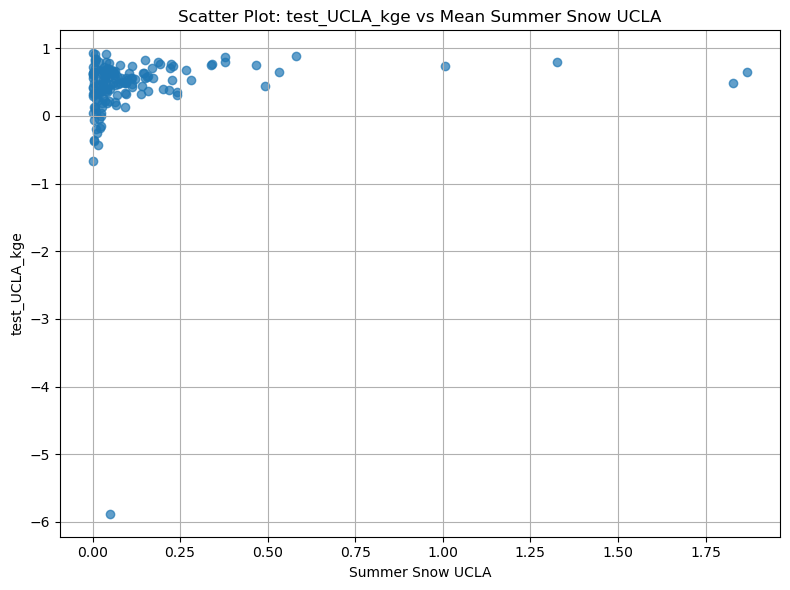

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(df_merged["Summer Snow Mean UCLA"], df_merged["test_UCLA_kge"], alpha=0.7)
plt.xlabel("Summer Snow UCLA")
plt.ylabel("test_UCLA_kge")
plt.title("Scatter Plot: test_UCLA_kge vs Mean Summer Snow UCLA")
plt.grid(True)
plt.tight_layout()
plt.show()


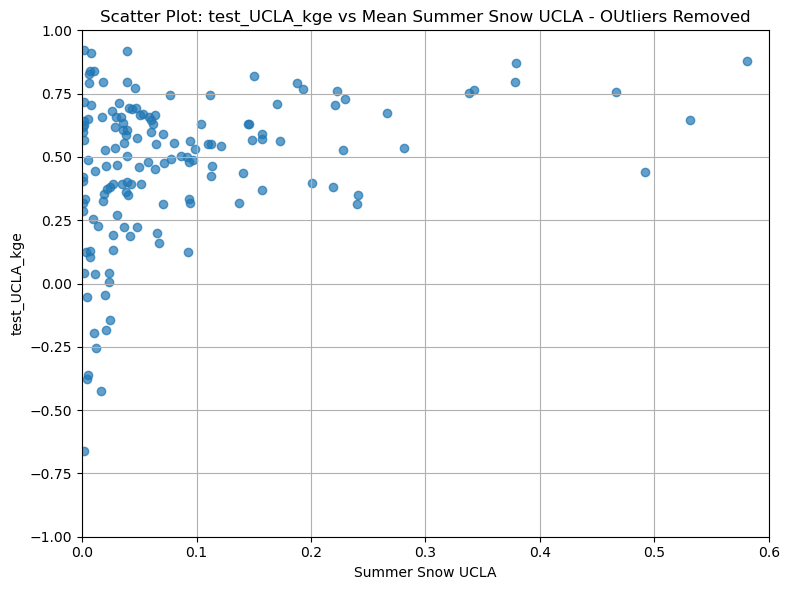

In [28]:
plt.figure(figsize=(8, 6))
plt.scatter(df_merged["Summer Snow Mean UCLA"], df_merged["test_UCLA_kge"], alpha=0.7)
plt.xlabel("Summer Snow UCLA")
plt.ylabel("test_UCLA_kge")
plt.title("Scatter Plot: test_UCLA_kge vs Mean Summer Snow UCLA - OUtliers Removed")
plt.xlim(0, 0.6)
plt.ylim(-1, 1)
plt.grid(True)
plt.tight_layout()
plt.show()
